In [2]:
import sys
sys.path.append('a/UltimeTradingBot/Crypto_backtest_tools')
from utilities.get_data import get_historical_from_db
from utilities.backtesting import basic_single_asset_backtest, plot_wallet_vs_asset, get_metrics
import pandas as pd
import ccxt
import matplotlib.pyplot as plt
import ta
import numpy as np
import random
from sklearn.utils import shuffle
import seaborn as sns
from utilities.backtesting import plot_wallet_vs_asset, get_metrics, get_n_columns, basic_multi_asset_backtest, plot_sharpe_evolution, plot_bar_by_month
from utilities.custom_indicators import SuperTrend
pd.options.mode.chained_assignment = None  # default='warn'


In [3]:

import tensorflow as tf
#tf.test.is_gpu_available(
#     cuda_only=False, min_cuda_compute_capability=None
# )
tf.config.list_physical_devices('GPU')



[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))

AttributeError: module 'tensorflow' has no attribute 'Session'

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
PRERR=False
def prerr(err):
    if PRERR:
        print("\033[0;31m Error in "+str(sys._getframe().f_code.co_name) +" \033[0;33m"+str(err))

In [7]:
#MetaData=get_crypto_metadata(Binance_USDT_HALAL)
MetaData = pd.read_csv("D:\+DATA+\MetaData.csv")
df = pd.read_csv('D:/+DATA+/allok_w15_nosell.csv',index_col=0)

In [4]:
#df=df.drop(columns="sell")
df=df.drop(columns=["Unnamed: 0"])
#df.to_csv('D:/+DATA+/allok_w15_nosell.csv')

In [ ]:
sys.getsizeof(df)/(1024**2)

## Testing impoted DATA

In [11]:
df[df['buy']==1]

,open,high,low,close,volume,high-1,low-1,open-1,close-1,volume-1,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy
5,0.259200,0.259300,0.254700,0.258000,38103.38,0.259900,0.257900,0.259000,0.259400,26573.45,...,52500.42,52066.99,52066.99,52469.49,909.313696,1,15,18,-117,1
6,0.000043,0.000043,0.000043,0.000043,47526628.00,0.000043,0.000043,0.000043,0.000043,21892392.00,...,29609.47,29536.22,29536.23,29564.50,272.084180,6,4,37,-611,1
7,0.052220,0.052220,0.052220,0.052220,218.60,0.052250,0.052240,0.052250,0.052240,814.50,...,19085.65,19052.62,19085.64,19076.30,120.363966,1,3,18,-314,1
11,3.036200,3.036200,3.008200,3.018100,101695.10,3.046600,3.035300,3.046500,3.035700,6457.70,...,39785.99,39713.50,39719.99,39767.99,125.824500,4,13,59,-741,1
17,0.287290,0.287900,0.286660,0.287710,45267.50,0.287900,0.286760,0.287350,0.287290,64389.70,...,35949.60,35861.24,35870.17,35912.68,219.663963,6,16,56,-335,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1084353,5.646400,5.677400,5.612800,5.666700,30206.87,5.674200,5.577100,5.604200,5.646400,46021.36,...,50077.90,49380.14,49952.49,50037.51,816.505984,2,7,17,-223,1
1084361,2.428000,2.431000,2.424000,2.430000,1538.10,2.434000,2.425000,2.434000,2.430000,1785.40,...,38834.02,38699.99,38700.00,38815.49,82.259800,3,0,39,-638,1
1084364,1.039700,1.040300,1.035000,1.036200,1597635.57,1.042000,1.039600,1.039800,1.039700,822241.14,...,39420.77,39271.96,39296.40,39288.07,605.105036,4,11,25,607,1
1084369,0.451630,0.451630,0.449670,0.451380,10695.90,0.452800,0.451660,0.451660,0.452730,4355.60,...,35776.57,35588.00,35773.34,35605.99,198.151291,1,0,22,98,1


In [12]:
df.iloc[1000037]["buy"]

0.0

Cheking null values

In [13]:
df[df.isnull().any(axis=1)]

,open,high,low,close,volume,high-1,low-1,open-1,close-1,volume-1,...,BTC_high-15_5min,BTC_low-15_5min,BTC_open-15_5min,BTC_close-15_5min,BTC_volume-15_5min,day,hour,minute,lunch_day,buy


checking keys

In [ ]:
for k in df.keys():print(k)

In [ ]:
del(allok)

# starting numpy process

## convert Pandas DataFrame to numpy object

In [5]:

dt = df.to_numpy()
dt


array([[ 4.8747e+00,  4.8747e+00,  4.8727e+00, ...,  1.5000e+01,
        -6.8500e+02,  0.0000e+00],
       [ 1.2014e+00,  1.2020e+00,  1.2009e+00, ...,  2.4000e+01,
         6.2400e+02,  0.0000e+00],
       [ 2.9010e-01,  2.9010e-01,  2.8999e-01, ...,  5.0000e+01,
        -6.1700e+02,  0.0000e+00],
       ...,
       [ 1.5099e+01,  1.5120e+01,  1.5087e+01, ...,  4.2000e+01,
         3.4800e+02,  0.0000e+00],
       [ 2.7710e-01,  2.7710e-01,  2.7690e-01, ...,  5.7000e+01,
         6.8000e+01,  0.0000e+00],
       [ 1.3220e-02,  1.3220e-02,  1.3210e-02, ...,  5.7000e+01,
        -3.9100e+02,  0.0000e+00]])

In [6]:
del(df)

In [7]:
dt.shape

(1084382, 765)

In [16]:
dt[97,-1]

0.0

### Shuffle the rows Again

In [8]:
np.random.shuffle(dt)

In [22]:
sys.getsizeof(dt)/(1024**2)

0.00011444091796875

In [ ]:
np.savetxt('np_shuffled_cryptodata_w15.csv', dt ,delimiter=',')



In [ ]:
dt=np.genfromtxt('np_shuffled_cryptodata_w15.csv', delimiter=',')

In [9]:
index_20percent= int(0.2*len(dt[:,0]))
print(index_20percent)

216876


In [10]:
XVALIDATION= dt[:index_20percent, :-1]
YVALIDATION= dt[:index_20percent,-1]


In [11]:
XTRAIN= dt[index_20percent:, 0:-1]
YTRAIN= dt[index_20percent:,-1]

## Normalization

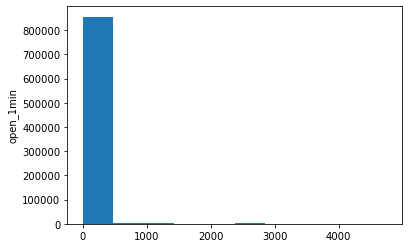

In [26]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open_1min")
plt.show()

In [ ]:
plt.hist(YTRAIN)
plt.ylabel("Output labels")
plt.show()

plt.hist(YVALIDATION)
plt.ylabel("Output labels")
plt.show()

Tenderalization (mean normalization)

In [12]:
mean = XTRAIN.mean(axis=0)
XTRAIN -= mean 
std = XTRAIN.std(axis=0)
XTRAIN /= std

XVALIDATION -=mean
XVALIDATION /= std

C:\Users\ayoub\AppData\Local\Temp/ipykernel_16072/2389388380.py:4: RuntimeWarning: divide by zero encountered in true_divide
  XTRAIN /= std
C:\Users\ayoub\AppData\Local\Temp/ipykernel_16072/2389388380.py:7: RuntimeWarning: divide by zero encountered in true_divide
  XVALIDATION /= std


In [ ]:
print(mean)
print(std)

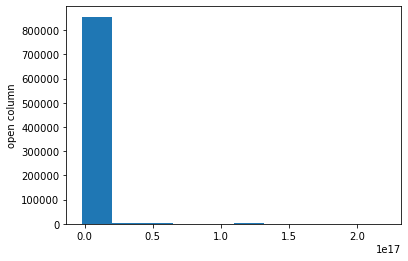

In [29]:
plt.hist(XTRAIN[:,0])
plt.ylabel("open column")
plt.show()

In [14]:
print(XTRAIN.shape)
print(YTRAIN.shape)
print(XVALIDATION.shape)
print(YVALIDATION.shape)

(867506, 764)
(867506,)
(216876, 764)
(216876,)


# Neural network model

The neural network architecture:
- layer 1 : 764 neurons
- layer 2 : 8 neurons
- layer 3 : neurons 

In [ ]:
IN_DIM=len(XTRAIN[0,:])
# model = Sequential()
# model.add(Dense(int(IN_DIM/2),input_dim=IN_DIM,activation='softplus'))
# model.add(Dropout(0.2))
# model.add(Dense(int(IN_DIM/4),activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(int(IN_DIM/6),activation='relu'))
# model.add(Dropout(0.4))

# model.add(Dense(1,activation='sigmoid'))
#code genrator
global All_Hist
try:
    with open('Results_history.json') as json_file:
        data = json.load(json_file)
except:
    All_Hist={0.000001:"code"}
def auto_code_gen():
    NumLayer=random.randint(1, 5)
    InpLay=int(random.randint(1, max(2,int(NumLayer/random.randint(3,NumLayer+4)+4))))
    act_func=['tanh','relu','sigmoid','softmax','softplus']
    dropout_val=[0.2,0.3,0.4,0.5,0.6,0.7]
    decreaser=1
    IN_DIM=len(XTRAIN[0,:])
    code="model.add(Dense(int(IN_DIM/"+str(InpLay)+"),input_dim=IN_DIM,activation=\'"+random.choice(act_func)+"\'))\n"
    for i in range(0,NumLayer):
        code+='model.add(Dense(int(IN_DIM/'+str(random.randint(1,max(2,(i+1)*2)+1))+'),activation=\''+random.choice(act_func)+'\'))\n'
        if random.choice([True,False]):
            code+='model.add(Dropout('+str(random.choice(dropout_val))+'))\n'
    code+='model.add(Dense(1,activation=\'sigmoid\'))'
    return code

def model_tester(max_tests=500):
    from tensorflow.keras.models import Sequential
    import json
    from tensorflow.keras.layers import Dense
    from tensorflow.keras.layers import Dropout 
    code=""
    for c in range(1,max_tests+1):
        model = Sequential()
        code=auto_code_gen()
        exec(code)
        print(model.summary())
        #model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        callbacks_a = ModelCheckpoint(filepath ='XcryptoAi_model.hdf5',monitor ='val_accuracy',save_best_only = True, save_weights = True)
        callbacks_b = EarlyStopping(monitor ='val_accuracy',mode='auto',patience=20,verbose=1)
        history = model.fit(XTRAIN,
                        YTRAIN,
                        validation_data=(XVALIDATION,YVALIDATION),
                        epochs=1200,
                        batch_size=5000,
                        callbacks=[callbacks_a,callbacks_b])

        print('##########################################################################')
        print(f"------val_accuracy-----> {'{0:.4g}'.format(max(history.history['val_accuracy'])*100)} | {'{0:.4g}'.format(max(history.history['accuracy'])*100)} <----------accuracy----------")
        All_Hist[max(history.history['val_accuracy'])]=code
        with open('Results_history.json', 'w') as fp:
            json.dump(All_Hist, fp,  indent=4)


model_tester(max_tests=500)

In [3]:
z={}
z[0.22]="eeee"
z[0.34]="ss"

z

{0.22: 'eeee', 0.34: 'ss'}

In [15]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense 

model = Sequential()
model.add(Dense(100,input_dim=len(XTRAIN[0,:]),activation='relu'))
model.add(Dense(20,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
print(model.summary())



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               76500     
                                                                 
 dense_1 (Dense)             (None, 20)                2020      
                                                                 
 dense_2 (Dense)             (None, 4)                 84        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 78,609
Trainable params: 78,609
Non-trainable params: 0
_________________________________________________________________
None


## Compile the model 

In [16]:
#model.compile(loss='binary_crossentropy',optimizer='adam',metric=['accuracy'])
model.compile(loss='binary_crossentropy',optimizer='rmsprop',metrics=['accuracy'])

### Train the model

In [17]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [18]:
callbacks_a = ModelCheckpoint(filepath ='D:/+DATA+/XcryptoAi_model.hdf5',monitor ='val_loss',save_best_only = True, save_weights = True)
callbacks_b = EarlyStopping(monitor ='val_loss',mode='min',patience=20,verbose=1)

In [19]:
history = model.fit(XTRAIN,YTRAIN,validation_data=(XVALIDATION,YVALIDATION),epochs=256,batch_size=10,callbacks=[callbacks_a,callbacks_b])

Epoch 1/256
86751/86751 [==============================] - 319s 4ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 2/256
86751/86751 [==============================] - 254s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 3/256
86751/86751 [==============================] - 275s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 4/256
86751/86751 [==============================] - 235s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 5/256
86751/86751 [==============================] - 257s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 6/256
86751/86751 [==============================] - 218s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010
Epoch 7/256
86751/86751 [==============================] - 232s 3ms/step - loss: nan - accuracy: 0.8020 - val_loss: nan - val_accuracy: 0.8010